# Emulate the RFMIP forcing from other SSPs

Forcing from SSPs is provided from a combination of

- greenhouse gases
- aerosols
- solar & volcanic (combined "natural")
- other anthropogenic
  - land use change
  - ozone
  
We wish to use the SSP2-4.5 model-specific ERFs from RFMIP and apply them to other scenarios. Do as follows:
- Greenhouse gases: isolate CO2 from other GHGs based on 4xCO2 and 2014 GHG ERFs. For other GHGs, scale the contribution of each according to Etminan/Meinshauen formulas.
- Aerosols: use emissions-based emulator developed in Smith et al. (2021)
- Solar and volcanic: can use RFMIP transient scenarios without modification
- Other anthropogenic:
  - land use change: use 2014 Tier 1 values, scale the time series to cumulative CO2 emissions 
  - ozone: residual of total - natural - aerosol - ghg - landuse

In [1]:
import errno
import json
import os
import urllib

from fair.forcing.ghg import meinshausen
import matplotlib.pyplot as pl
from netCDF4 import Dataset
import numpy as np
import pandas as pd

In [2]:
scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
emitted_species = ['BC', 'OC', 'Sulfur']
emissions = {}

In [3]:
def check_and_download(filepath, url):
    """Checks prescence of a file and downloads if not present.

    Inputs
    ------
        filepath : str
            filename to download to
        url :
            url to download from
    """
    if not os.path.isfile(filepath):
        urllib.request.urlretrieve(url, filepath)
    return

In [4]:
check_and_download('../data_input/rcmip/rcmip-emissions-annual-means-v5-1-0.csv', 'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-emissions-annual-means-v5-1-0.csv')

## Aerosols will be easiest

In [5]:
emissions_df = pd.read_csv('../data_input/rcmip/rcmip-emissions-annual-means-v5-1-0.csv')

In [6]:
for scenario in scenarios:
    emissions[scenario] = {}
    for specie in emitted_species:
        emissions[scenario][specie] = emissions_df.loc[
            (emissions_df['Scenario']==scenario) & 
            (emissions_df['Variable']=='Emissions|{}'.format(specie)) &
            (emissions_df['Region']=='World'), 
            '1850':'2100'
        ].interpolate(axis=1).values.squeeze()

In [7]:
with open('../data_output/cmip6_aerosol_coefficients.json') as f:
    aerosol_tunings = json.load(f)

In [8]:
models = [
    'CanESM5',
    'CNRM-CM6-1',
    'GFDL-CM4',
    'GISS-E2-1-G',
    'HadGEM3-GC31-LL',
    'IPSL-CM6A-LR',
    'MIROC6',
    'NorESM2-LM',
]

In [9]:
models

['CanESM5',
 'CNRM-CM6-1',
 'GFDL-CM4',
 'GISS-E2-1-G',
 'HadGEM3-GC31-LL',
 'IPSL-CM6A-LR',
 'MIROC6',
 'NorESM2-LM']

In [10]:
aerosol_tunings[models[0]]['ERFari']['BC']

0.03259343948789619

In [11]:
erf = {}
for model in models:
    erf[model] = {}
    for scenario in scenarios:
        erf[model][scenario] = {}

In [12]:
def aerocom(x, bc, oc, so2):
    return bc*x[0] + oc*x[1] + so2*x[2]

def ghan(x, beta, n0, n1):
    return -beta*np.log(1 + x[0]/n0 + x[1]/n1)

In [13]:
for model in models:
    for scenario in scenarios:
        x_ari = np.array([emissions[scenario]['BC'], emissions[scenario]['OC'], emissions[scenario]['Sulfur']])
        x_aci = np.array([emissions[scenario]['Sulfur'], emissions[scenario]['BC']+emissions[scenario]['OC']])
        erf[model][scenario]['aerosol'] = (
            aerocom(
                x_ari,
                aerosol_tunings[model]['ERFari']['BC'],
                aerosol_tunings[model]['ERFari']['OC'],
                aerosol_tunings[model]['ERFari']['SO2'],
            ) - aerocom(
                x_ari[:, 0],
                aerosol_tunings[model]['ERFari']['BC'],
                aerosol_tunings[model]['ERFari']['OC'],
                aerosol_tunings[model]['ERFari']['SO2'],
            )
        ) + (
            ghan(
                x_aci,
                aerosol_tunings[model]['ERFaci']['beta'],
                aerosol_tunings[model]['ERFaci']['n0'],
                aerosol_tunings[model]['ERFaci']['n1'],
            ) - ghan(
                x_aci[:, 0],
                aerosol_tunings[model]['ERFaci']['beta'],
                aerosol_tunings[model]['ERFaci']['n0'],
                aerosol_tunings[model]['ERFaci']['n1'],
            )
        )

In [14]:
# only need to fill in HadGEM3 for 2100, CNRM and NorESM2
rfmip_tier2 = pd.read_csv('../data_input/RFMIP-ERF-tier2.csv', index_col=0)
natural = rfmip_tier2[['CanESM5 NAT', 'CNRM-CM6-1 NAT', 'GFDL-CM4 NAT', 'GISS-E2-1-G NAT', 'HadGEM3-GC31-LL NAT', 'IPSL-CM6A-LR NAT', 'MIROC6 NAT', 'NorESM2-LM NAT']]
natural

,CanESM5 NAT,CNRM-CM6-1 NAT,GFDL-CM4 NAT,GISS-E2-1-G NAT,HadGEM3-GC31-LL NAT,IPSL-CM6A-LR NAT,MIROC6 NAT,NorESM2-LM NAT
year,,,,,,,,
1850,0.437284,-0.293584,0.127826,0.109629,0.217894,0.193991,-0.037077,0.351767
1851,0.003158,-0.229548,0.223375,-0.329789,0.280323,0.193944,0.231050,0.195244
1852,-0.202280,-0.012110,0.199512,0.149565,0.137737,-0.098239,0.075457,-0.077189
1853,-0.161843,-0.170152,0.166399,-0.105968,0.189263,0.219294,-0.145791,0.339919
1854,0.061468,-0.003006,0.364801,0.011749,0.158687,0.168342,0.149833,-0.216705
...,...,...,...,...,...,...,...,...
2096,0.154930,NaN,-0.133315,0.181825,0.103691,0.169500,0.163041,NaN
2097,0.008238,NaN,-0.067166,-0.009377,0.154095,0.008598,0.014279,NaN
2098,-0.016735,NaN,-0.162721,0.127037,0.031064,0.134732,-0.153561,NaN


In [15]:
# replace historcial and SSP2-4.5 only with model results
for model in models:
    for scenario in scenarios:
        erf[model][scenario]['aerosol'][:165] = rfmip_tier2.loc[:2014, '%s AER' % model]
        
    if model not in ['NorESM2-LM', 'CNRM-CM6-1', 'HadGEM3-GC31-LL']:
        erf[model]['ssp245']['aerosol'][165:] = rfmip_tier2.loc[2015:, '%s AER' % model]
    
    if model=='HadGEM3-GC31-LL':
        erf[model]['ssp245']['aerosol'][165:250] = rfmip_tier2.loc[2015:2099, '%s AER' % model]

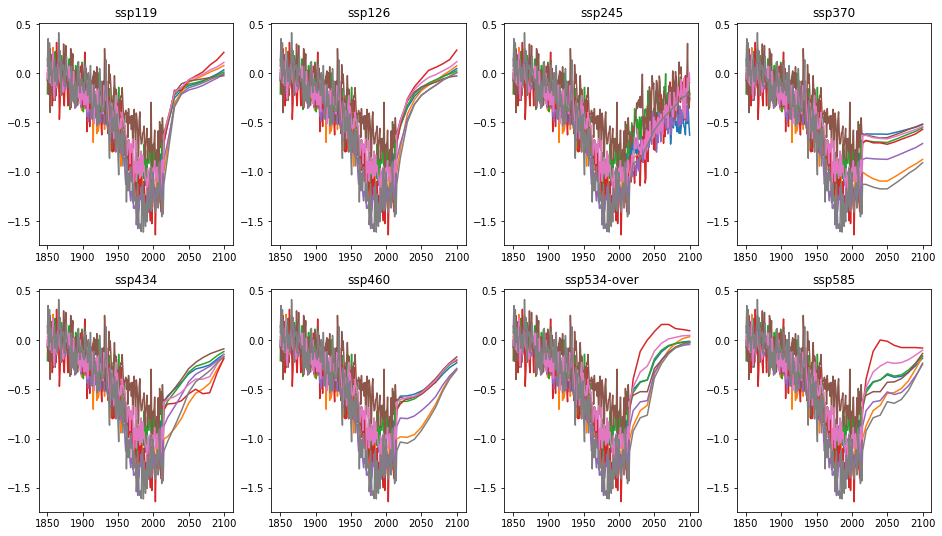

In [16]:
fig, ax = pl.subplots(2, 4, figsize=(16,9))

for iscen, scenario in enumerate(scenarios):
    for model in models:
        ax[iscen//4, iscen%4].plot(np.arange(1850, 2101), erf[model][scenario]['aerosol'])
        ax[iscen//4, iscen%4].set_title(scenario)

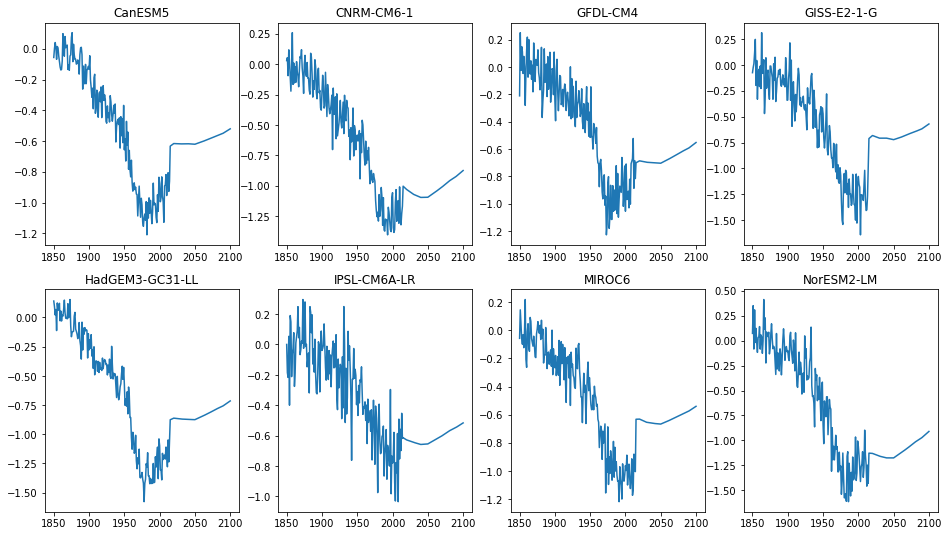

In [17]:
fig, ax = pl.subplots(2, 4, figsize=(16,9))

for imod, model in enumerate(models):
    ax[imod//4, imod%4].plot(np.arange(1850, 2101), erf[model]['ssp370']['aerosol'])
    ax[imod//4, imod%4].set_title(model)

## Natural will be second easiest

- Isolate volcanic and solar in the 8 models
- We know that volcanic ramps to zero 2015-2024, so any residual natural forcing is solar in any model that didn't run the natural experiment beyond 2014

In [18]:
# Reproduce the solar forcing calculation

nc_future = Dataset('../data_input/input4mips/solarforcing-ref-mon_input4MIPs_solar_CMIP_SOLARIS-HEPPA-3-2_gn_185001-229912.nc')
tsi_future = nc_future.variables['tsi'][:(251*12)]
nc_future.close()

years = np.arange(1850, 2101, dtype=int)
isleap = np.zeros(251)
isleap[np.logical_and(years%4==0, np.logical_or(years%100!=0, years%400==0))] = 1

tsi = np.zeros(251)
for i, year in enumerate(years):
    weights = [31,28+isleap[i],31,30,31,30,31,31,30,31,30,31]
    tsi[i] = np.average(tsi_future[(i)*12:(1+i)*12], weights=weights)

tsi_baseline = np.mean(tsi[:24])
tsi_baseline
solar_erf = 0.25 * (tsi-tsi_baseline) * 0.71 * 0.72  # include RA

In [19]:
for model in models:
    for scenario in scenarios:
        erf[model][scenario]['natural'] = natural.loc[:, '%s NAT' % model].values

In [20]:
for scenario in scenarios:
    erf['HadGEM3-GC31-LL'][scenario]['natural'][250] = solar_erf[250]

In [21]:
for model in ['CNRM-CM6-1', 'NorESM2-LM']:
    for scenario in scenarios:
        erf[model][scenario]['natural'][174:] = solar_erf[174:]
        erf[model][scenario]['natural'][165:174] = (natural.loc[2014, '%s NAT' % model] - solar_erf[164]) * np.linspace(0.9,0.1,9) + solar_erf[165:174]

In [22]:
(natural.loc[2014, '%s NAT' % model] - solar_erf[164]) * np.linspace(0.9,0.1,9) + solar_erf[165:174]

array([-0.00727194, -0.03914519, -0.04409948, -0.04317538, -0.03895563,
       -0.02882632,  0.01262463,  0.05738552,  0.08489913])

In [23]:
erf[model][scenario]['natural']

array([ 3.51766762e-01,  1.95244099e-01, -7.71886611e-02,  3.39918933e-01,
       -2.16705422e-01,  2.48576523e-01,  1.91765264e-01,  3.33144697e-01,
        4.81657592e-01,  3.23124181e-01,  2.40259084e-01, -4.38974316e-01,
       -3.71809506e-01, -1.68228121e-01, -2.02487143e-01,  2.04098112e-01,
       -2.17552228e-01,  2.97724106e-02,  1.11455344e-01, -5.46826260e-02,
       -1.81695857e-02, -5.92861785e-02,  3.36247813e-01, -3.81966512e-02,
       -2.96038655e-02,  2.77229272e-01,  1.86463624e-01,  3.93925026e-01,
        3.57092328e-01,  3.40449826e-01, -2.27644899e-01,  1.87330337e-01,
        1.46098829e-01, -8.25158562e-01, -2.52381245e+00, -7.96936186e-01,
        3.74143624e-01,  6.87624202e-02,  1.03881195e-01,  2.46133096e-01,
        1.13119385e-01, -5.79577240e-01,  1.29466052e-01,  2.33712707e-01,
        5.35870291e-01, -1.36592232e-01, -1.44612995e-01,  2.39858455e-01,
       -1.54811479e-01, -2.30651445e-01,  7.63780331e-03, -5.12486321e-02,
       -4.20675643e-01, -

CanESM5
CNRM-CM6-1
GFDL-CM4
GISS-E2-1-G
HadGEM3-GC31-LL
IPSL-CM6A-LR
MIROC6
NorESM2-LM


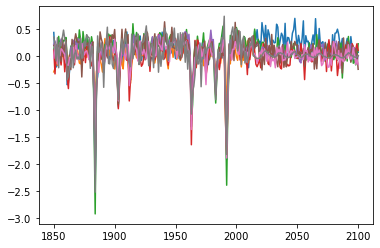

In [24]:
for model in models:
    print(model)
    pl.plot(np.arange(1850, 2101), erf[model]['ssp245']['natural'])

## Greenhouse gases

- We have SSP2-4.5, or at least historical
- estimate contributions from CO2, CH4, N2O, HFC134a-eq, CFC11-eq

In [25]:
co2 = rfmip_tier2[['CanESM5 CO2', 'CNRM-CM6-1 CO2', 'GFDL-CM4 CO2', 'GISS-E2-1-G CO2', 'HadGEM3-GC31-LL CO2', 'IPSL-CM6A-LR CO2', 'MIROC6 CO2', 'NorESM2-LM CO2']]
co2

,CanESM5 CO2,CNRM-CM6-1 CO2,GFDL-CM4 CO2,GISS-E2-1-G CO2,HadGEM3-GC31-LL CO2,IPSL-CM6A-LR CO2,MIROC6 CO2,NorESM2-LM CO2
year,,,,,,,,
1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1851,0.002390,0.002514,0.002588,0.002284,0.002542,0.002514,0.002301,0.002562
1852,0.005011,0.005270,0.005426,0.004788,0.005329,0.005271,0.004825,0.005370
1853,0.007382,0.007762,0.007992,0.007052,0.007849,0.007764,0.007107,0.007910
1854,0.009430,0.009916,0.010210,0.009010,0.010028,0.009919,0.009079,0.010105
...,...,...,...,...,...,...,...,...
2096,3.938643,4.141469,4.264188,3.762960,4.188054,4.142554,3.791901,4.220562
2097,3.942577,4.145605,4.268447,3.766719,4.192237,4.146692,3.795688,4.224777
2098,3.946043,4.149250,4.272199,3.770030,4.195923,4.150337,3.799025,4.228491


In [26]:
ghg = rfmip_tier2[['CanESM5 GHG', 'CNRM-CM6-1 GHG', 'GFDL-CM4 GHG', 'GISS-E2-1-G GHG', 'HadGEM3-GC31-LL GHG', 'IPSL-CM6A-LR GHG', 'MIROC6 GHG', 'NorESM2-LM GHG']]
ghg

,CanESM5 GHG,CNRM-CM6-1 GHG,GFDL-CM4 GHG,GISS-E2-1-G GHG,HadGEM3-GC31-LL GHG,IPSL-CM6A-LR GHG,MIROC6 GHG,NorESM2-LM GHG
year,,,,,,,,
1850,-0.070117,0.030065,-0.033743,-0.071492,0.211614,0.000196,-0.190087,0.013559
1851,0.049519,-0.296073,0.033094,-0.222006,0.080624,0.123353,-0.021020,-0.174621
1852,-0.058389,-0.012057,0.055244,-0.142218,-0.125380,0.214244,0.114233,-0.026271
1853,0.058551,0.000254,0.118728,-0.071632,0.069717,-0.077474,0.108609,0.037472
1854,-0.196640,-0.007993,0.098336,-0.076394,0.330893,0.088221,0.061878,0.207066
...,...,...,...,...,...,...,...,...
2096,4.902642,NaN,5.453197,5.135131,5.546199,5.274178,4.757899,NaN
2097,5.016687,NaN,5.480755,5.151356,5.451873,5.267454,4.674509,NaN
2098,5.103812,NaN,5.675963,5.135182,5.514550,5.251549,4.684571,NaN


In [27]:
nonco2 = rfmip_tier2[['CanESM5 nonCO2', 'CNRM-CM6-1 nonCO2', 'GFDL-CM4 nonCO2', 'GISS-E2-1-G nonCO2', 'HadGEM3-GC31-LL nonCO2', 'IPSL-CM6A-LR nonCO2', 'MIROC6 nonCO2', 'NorESM2-LM nonCO2']]
nonco2

,CanESM5 nonCO2,CNRM-CM6-1 nonCO2,GFDL-CM4 nonCO2,GISS-E2-1-G nonCO2,HadGEM3-GC31-LL nonCO2,IPSL-CM6A-LR nonCO2,MIROC6 nonCO2,NorESM2-LM nonCO2
year,,,,,,,,
1850,0.191668,-0.293584,0.150924,0.051074,0.188223,0.139926,-0.040836,-0.115205
1851,0.159663,-0.115370,0.203701,0.100227,0.150724,0.055536,0.197992,0.182755
1852,-0.015938,0.041027,0.212412,0.165229,0.269396,0.221400,0.116770,0.115408
1853,0.180543,-0.018629,0.237831,0.127189,0.257526,0.059345,0.205334,0.531864
1854,-0.031909,0.026529,0.181610,-0.303244,0.175967,0.296340,0.134610,-0.048962
...,...,...,...,...,...,...,...,...
2096,0.908086,NaN,0.953662,1.390424,0.591074,1.121443,0.775515,NaN
2097,0.908642,NaN,0.927200,1.528070,0.655859,1.078013,0.654846,NaN
2098,0.944170,NaN,0.873375,1.663476,0.557593,1.048969,0.748400,NaN


In [28]:
check_and_download('../data_input/rcmip/rcmip-concentrations-annual-means-v5-1-0.csv', 'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-concentrations-annual-means-v5-1-0.csv')

In [29]:
radeff = {
    'HFC125':     0.23,
    'HFC134a':    0.16,
    'HFC143a':    0.16,
    'HFC152a':    0.10,
    'HFC227ea':   0.26,
    'HFC23':      0.18,
    'HFC236fa':   0.24309707,
    'HFC245fa':   0.24,
    'HFC32':      0.11,
    'HFC365mfc':  0.22261699,
    'HFC4310mee': 0.42,
    'NF3':        0.20467908,
    'C2F6':       0.25,
    'C3F8':       0.27730479,
    'C4F10':      0.36298028,
    'C5F12':      0.40512062,
    'C6F14':      0.44,
    'C7F16':      0.50171525,
    'C8F18':      0.55174034,
    'CF4':        0.09,
    'cC4F8':      0.31526465,
    'SF6':        0.57,
    'SO2F2':      0.20119879,
    'CCl4':       0.17,
    'CFC11':      0.26,
    'CFC113':     0.30,
    'CFC114':     0.31,
    'CFC115':     0.20,
    'CFC12':      0.32,
    'CH2Cl2':     0.0312,
    'CH3Br':      0.004,
    'CH3CCl3':    0.07,
    'CH3Cl':      0.01,
    'CHCl3':      0.07796969,
    'HCFC141b':   0.16,
    'HCFC142b':   0.19,
    'HCFC22':     0.21,
    'Halon1211':  0.29,
    'Halon1301':  0.30,
    'Halon2402':  0.31
}

gases=['HFC125','HFC134a','HFC143a','HFC152a','HFC227ea','HFC23','HFC236fa','HFC245fa','HFC32','HFC365mfc','HFC4310mee',
      'NF3','C2F6','C3F8','CF4','cC4F8','SF6','SO2F2','CCl4','CFC11','CFC113',
      'CFC114','CFC115','CFC12','CH2Cl2','CH3Br','CH3CCl3','CH3Cl','CHCl3','HCFC141b','HCFC142b','HCFC22','Halon1211',
      'Halon1301','Halon2402']

In [30]:
df_rcmip = pd.read_csv('../data_input/rcmip/rcmip-concentrations-annual-means-v5-1-0.csv')
conc = {}
ghg_forcing_ratio = {}
forcing = {}
for scenario in scenarios:
    conc = {}
    ghg_forcing_ratio[scenario] = {}
    conc['CO2'] = np.squeeze(df_rcmip[(df_rcmip.Scenario==scenario)&(df_rcmip.Variable=='Atmospheric Concentrations|CO2')&(df_rcmip.Region=='World')].loc[:,'1850':'2100'].values)
    conc['CH4'] = np.squeeze(df_rcmip[(df_rcmip.Scenario==scenario)&(df_rcmip.Variable=='Atmospheric Concentrations|CH4')&(df_rcmip.Region=='World')].loc[:,'1850':'2100'].values)
    conc['N2O'] = np.squeeze(df_rcmip[(df_rcmip.Scenario==scenario)&(df_rcmip.Variable=='Atmospheric Concentrations|N2O')&(df_rcmip.Region=='World')].loc[:,'1850':'2100'].values)

    for gas in gases:
        conc[gas] = np.squeeze(df_rcmip[(df_rcmip.Scenario==scenario)&(df_rcmip.Variable.str.endswith(gas))&(df_rcmip.Region=='World')].loc[:,'1850':'2100'].values)

    forcing[scenario] = {}
    forcing[scenario]["CO2"] = np.zeros(251)
    forcing[scenario]["CH4"] = np.zeros(251)
    forcing[scenario]["N2O"] = np.zeros(251)
    forcing[scenario]["Other"] = np.zeros(251)
    for gas in gases:
        for i,year in enumerate(range(1850,2101)):
            forcing[scenario]["CO2"][i], forcing[scenario]["CH4"][i], forcing[scenario]["N2O"][i] = meinshausen([conc['CO2'][i],conc['CH4'][i],conc['N2O'][i]], [conc['CO2'][0],conc['CH4'][0],conc['N2O'][0]], scale_F2x=False)
            forcing[scenario]["Other"][i] = forcing[scenario]["Other"][i] + ((conc[gas][i] - conc[gas][0]) * radeff[gas] * 0.001)
    forcing[scenario]['Total'] = forcing[scenario]["CO2"] + forcing[scenario]["CH4"] + forcing[scenario]["N2O"] + forcing[scenario]["Other"]
    ghg_forcing_ratio[scenario]['CO2'] = forcing[scenario]["CO2"]/forcing[scenario]['Total']
    ghg_forcing_ratio[scenario]['CH4'] = forcing[scenario]["CH4"]/forcing[scenario]['Total']
    ghg_forcing_ratio[scenario]['N2O'] = forcing[scenario]["N2O"]/forcing[scenario]['Total']
    ghg_forcing_ratio[scenario]['Other'] = forcing[scenario]["Other"]/forcing[scenario]['Total']

/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_40763/1417851663.py:25: RuntimeWarning: invalid value encountered in true_divide
  ghg_forcing_ratio[scenario]['CO2'] = forcing[scenario]["CO2"]/forcing[scenario]['Total']
/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_40763/1417851663.py:26: RuntimeWarning: invalid value encountered in true_divide
  ghg_forcing_ratio[scenario]['CH4'] = forcing[scenario]["CH4"]/forcing[scenario]['Total']
/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_40763/1417851663.py:27: RuntimeWarning: invalid value encountered in true_divide
  ghg_forcing_ratio[scenario]['N2O'] = forcing[scenario]["N2O"]/forcing[scenario]['Total']
/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_40763/1417851663.py:28: RuntimeWarning: invalid value encountered in true_divide
  ghg_forcing_ratio[scenario]['Other'] = forcing[scenario]["Other"]/forcing[scenario]['Total']


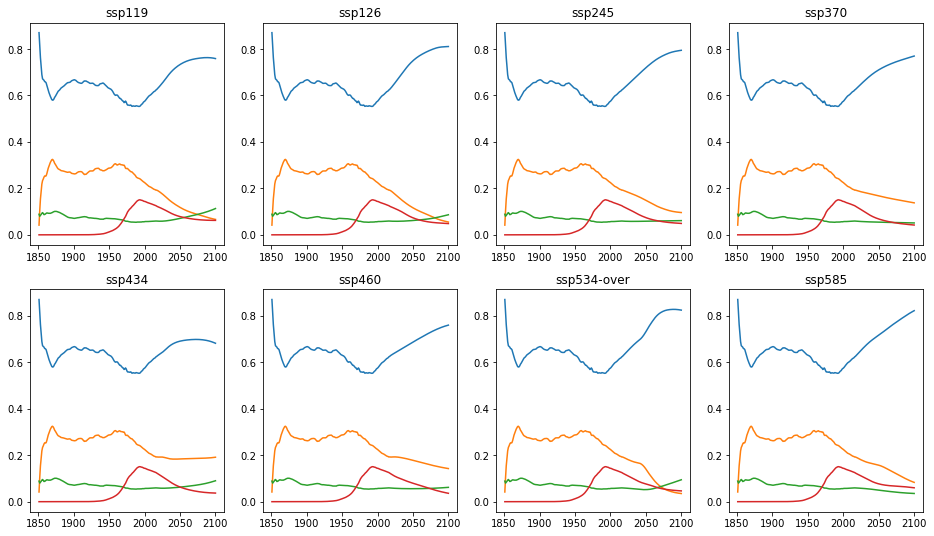

In [31]:
fig, ax = pl.subplots(2, 4, figsize=(16,9))

for iscen, scenario in enumerate(scenarios):
    for gas in ["CO2", "CH4", "N2O", "Other"]:
        ax[iscen//4, iscen%4].plot(np.arange(1850, 2101), ghg_forcing_ratio[scenario][gas])
    ax[iscen//4, iscen%4].set_title(scenario)

In [32]:
rfmip_tier1 = pd.read_csv('../data_input/RFMIP-ERF-tier1.csv', index_col=0)
rfmip_tier1.loc['CanESM5', 'ghg']

2.8665463345516327

In [33]:
rfmip_tier1

,4xCO2,aer,anthro,ghg,lu
ACCESS-CM2,7.947339,-1.093110,1.899132,3.037905,NaN
CanESM5,7.607363,-0.851293,2.373742,2.866546,-0.076129
CESM2,8.912768,-1.371578,2.052586,3.034886,-0.036949
CNRM-CM6-1,7.999114,-1.154830,1.611382,2.742752,NaN
CNRM-ESM2-1,7.926313,-0.740564,1.662861,2.507754,-0.066677
EC-Earth3,8.087878,-0.803576,2.094420,2.745401,-0.127910
GFDL-CM4,8.236141,-0.731706,2.338378,3.133760,-0.333075
GFDL-ESM4,7.743827,-0.697921,2.171352,3.225829,-0.275541
GISS-E2-1-G,7.349846,-1.318632,1.929006,2.893540,-0.000406
GISS-E2-1-G,NaN,-0.927439,NaN,NaN,NaN


In [34]:
ghg_forcing_ratio_2014 = {}
ghg_forcing_ratio_2014['CO2'] = ghg_forcing_ratio[scenario]['CO2'][164]
ghg_forcing_ratio_2014['CH4'] = ghg_forcing_ratio[scenario]['CH4'][164]
ghg_forcing_ratio_2014['N2O'] = ghg_forcing_ratio[scenario]['N2O'][164]
ghg_forcing_ratio_2014['Other'] = ghg_forcing_ratio[scenario]['Other'][164]

ghg_forcing_2014 = {}
for model in models:
    ghg_forcing_2014[model] = {}
    for scenario in scenarios:
        ghg_forcing_2014[model][scenario] = {}
        ghg_forcing_2014[model][scenario]['CO2'] = ghg_forcing_ratio[scenario]['CO2'][164] * np.nanmean(rfmip_tier1.loc[model, 'ghg'])
        ghg_forcing_2014[model][scenario]['CH4'] = ghg_forcing_ratio[scenario]['CH4'][164] * np.nanmean(rfmip_tier1.loc[model, 'ghg'])
        ghg_forcing_2014[model][scenario]['N2O'] = ghg_forcing_ratio[scenario]['N2O'][164] * np.nanmean(rfmip_tier1.loc[model, 'ghg'])
        ghg_forcing_2014[model][scenario]['Other'] = ghg_forcing_ratio[scenario]['Other'][164] * np.nanmean(rfmip_tier1.loc[model, 'ghg'])

In [35]:
ghg_forcing_2014[model][scenario]

{'CO2': 1.726458909397043,
 'CH4': 0.5466650985408976,
 'N2O': 0.1655415058403473,
 'Other': 0.358385409595826}

In [36]:
ghg_forcing_2014[model][scenario]['CO2']/rfmip_tier1.loc[model, 'ghg']

0.6172425732293769

In [37]:
ghg_forcing_ratio[scenario]['CO2'][164]

0.6172425732293769

In [38]:
for model in models:
    for scenario in scenarios:
        erf[model][scenario]['ghg'] = forcing[scenario]['Total']/forcing['ssp245']['Total'] * ghg["%s GHG" % model].values
    
        # all models: fill in 1850 from same historical run
        erf[model][scenario]['ghg'][0] = forcing['ssp245']['Total'][0]
        
        # extend models beyond 2014
        if model in ['CNRM-CM6-1', 'NorESM2-LM']:
            total = 0
            for forcer in ["CO2", "CH4", "N2O", "Other"]:
                total = total + (
                    forcing[scenario][forcer]/forcing[scenario][forcer][164] * ghg_forcing_2014[model][scenario][forcer]
            )
            erf[model][scenario]['ghg'][165:] = total[165:]

        if model=='HadGEM3-GC31-LL':
            total = 0
            for forcer in ["CO2", "CH4", "N2O", "Other"]:
                total = total + (
                    forcing[scenario][forcer]/forcing[scenario][forcer][164] * ghg_forcing_2014[model][scenario][forcer]
            )
            erf[model][scenario]['ghg'][250] = total[250]

/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_40763/2576643743.py:3: RuntimeWarning: invalid value encountered in true_divide
  erf[model][scenario]['ghg'] = forcing[scenario]['Total']/forcing['ssp245']['Total'] * ghg["%s GHG" % model].values


In [39]:
erf[model][scenario]

{'aerosol': array([ 0.07198662,  0.34967076, -0.08487394,  0.30725785, -0.01904648,
         0.12173385, -0.02142862, -0.11816419,  0.03027099,  0.03845253,
         0.13984629, -0.08530294,  0.05646498,  0.03619322, -0.12721157,
        -0.00335717,  0.41084432,  0.11405638,  0.22725736, -0.22474028,
         0.08587346,  0.04991939,  0.04047235,  0.08358976, -0.13314979,
        -0.07443391,  0.06879545,  0.16788383,  0.01434141, -0.08176546,
        -0.05798917, -0.07553647, -0.20103199, -0.33915936,  0.07055685,
        -0.28439277, -0.12309776, -0.13987931, -0.30407534, -0.08272622,
        -0.13468879, -0.34321659, -0.18679851,  0.00561241,  0.11752467,
        -0.00167449, -0.19745399, -0.08695859, -0.05974014, -0.11054884,
        -0.10031817, -0.17334311, -0.2001885 ,  0.04515032,  0.08241986,
        -0.0926648 , -0.15279418, -0.22663907,  0.00537775, -0.07145863,
        -0.30334545,  0.07747563, -0.21694951, -0.45297536, -0.46837725,
        -0.32025462, -0.11527085, -0.341

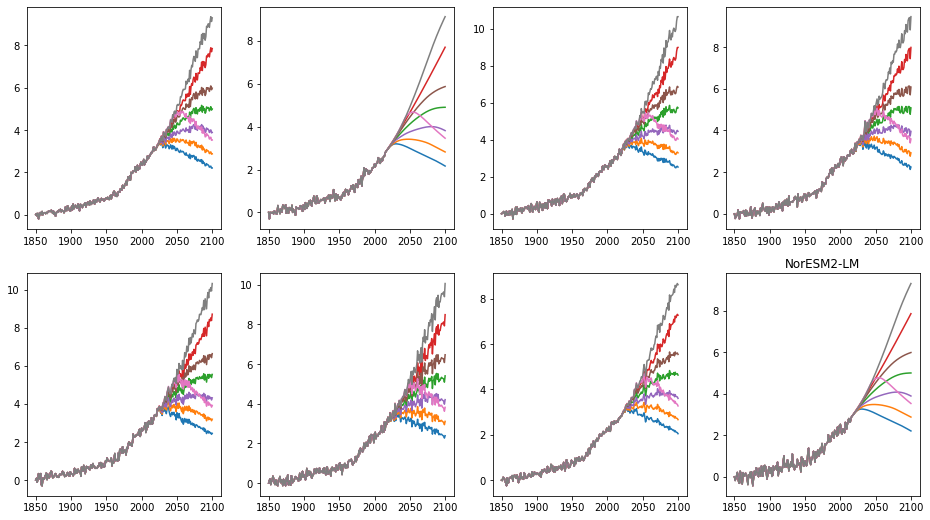

In [40]:
fig, ax = pl.subplots(2, 4, figsize=(16,9))

for iscen, scenario in enumerate(scenarios):
    for imod, model in enumerate(models):
        ax[imod//4, imod%4].plot(np.arange(1850, 2101), erf[model][scenario]['ghg'])
    ax[imod//4, imod%4].set_title(model)